In [1]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [2]:
data=pd.read_csv('df_train.csv')
data = data.dropna()

In [3]:
X = data['text']
Y = data['target']

train_X , val_X, train_y, val_y = train_test_split(X, Y, test_size=0.1, random_state=42)

In [4]:
text_cols = ['text']
target_col = 'target'

In [5]:
type(train_X)

pandas.core.series.Series

In [6]:
label = np.sort(train_y.unique()).tolist()

In [7]:
pd.DataFrame(train_X)

,text
245,американский стартап spatial представил смесь ...
5364,приложении презентация practices migrating big...
179,концепция женщин взошла хотел женщин работают ...
6922,waiting game 24 waiting game steps asylum seek...
17,смотрите фильмы играете игры оригинальной озву...
...,...
5226,visualization often described context speed ef...
5390,24ddeb81e872e495c6265 деньги финансовый дашбор...
860,привет интересный вариант специалистов области...
7603,cool frineds clutch chose 300 highest performi...


In [8]:
y_preds = []
models = []
oof_train = np.zeros((len(train_X),))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [20]:
catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.01,
    'eval_metric': 'AUC',
    'loss_function': 'MultiClass',
    'task_type': 'GPU',
    'early_stopping_rounds': 1000,
    'use_best_model': True,
    'objective':"MultiClass",
    'verbose': 100
}

In [21]:
X_tr = pd.DataFrame(train_X) #X_train
X_val =  pd.DataFrame(val_X)
y_tr = train_y
y_val = val_y

train_pool = Pool(
    X_tr, 
    y_tr, 
    text_features=text_cols
)
valid_pool = Pool(
    X_val, 
    y_val, 
    text_features=text_cols
)

In [22]:
model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7544551	best: 0.7544551 (0)	total: 8.39ms	remaining: 1m 23s
100:	test: 0.7977564	best: 0.7977564 (100)	total: 659ms	remaining: 1m 4s
200:	test: 0.8138857	best: 0.8138857 (200)	total: 1.28s	remaining: 1m 2s
300:	test: 0.8250449	best: 0.8250449 (300)	total: 1.85s	remaining: 59.5s
400:	test: 0.8339745	best: 0.8339745 (400)	total: 2.37s	remaining: 56.7s
500:	test: 0.8407700	best: 0.8407700 (500)	total: 2.91s	remaining: 55.1s
600:	test: 0.8476808	best: 0.8476808 (600)	total: 3.44s	remaining: 53.8s
700:	test: 0.8522739	best: 0.8522739 (700)	total: 3.97s	remaining: 52.7s
800:	test: 0.8572018	best: 0.8572018 (800)	total: 4.52s	remaining: 51.9s
900:	test: 0.8620334	best: 0.8620334 (900)	total: 5.09s	remaining: 51.4s
1000:	test: 0.8659754	best: 0.8659754 (1000)	total: 5.64s	remaining: 50.8s
1100:	test: 0.8697014	best: 0.8697014 (1100)	total: 6.2s	remaining: 50.1s
1200:	test: 0.8730689	best: 0.8730689 (1200)	total: 6.73s	remaining: 49.3s
1300:	test: 0.8760630	best: 0.8760630 (1300)	tot

In [23]:
#oof_train[0] = model.predict_proba(X_val)[:, 1]

y_pred = model.predict(X_val,prediction_type='Probability')#[:, 1]
y_pred = model.predict(X_val,prediction_type='Class')#[:, 1]
#y_pred = model.predict(X_val)
y_preds.append(y_pred)
models.append(model)

In [24]:
def get_confusion_matrix(val_y, pred, title):
    cm = confusion_matrix(val_y, pred, labels=label)
    #plt.figure(figsize=(15, 15))
    #sns.heatmap(cm, annot=True)
    #plt.title(title)
    #plt.ylabel("True labels")
    #plt.xlabel("Predicted labels")
    #plt.show()
    fig = plt.figure(figsize=(15, 15))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cbar=False, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix' + title); 
    ax.xaxis.set_ticklabels(label);
    ax.yaxis.set_ticklabels(label);


def get_roc_curve(val_y, pred_probs, title):
    #plt.figure(figsize=(15, 15))
    plt.title(title)
    skplt.metrics.plot_roc(val_y, pred_probs, figsize=(15, 15))

In [25]:
val_y.shape

(802,)

In [26]:
val_y

4523    2
4680    0
5832    1
3827    0
2470    1
       ..
5643    1
7340    2
50      1
5507    1
733     2
Name: target, Length: 802, dtype: int64

In [27]:
y_preds[0].shape

(802, 1)

In [28]:
y_preds[0];

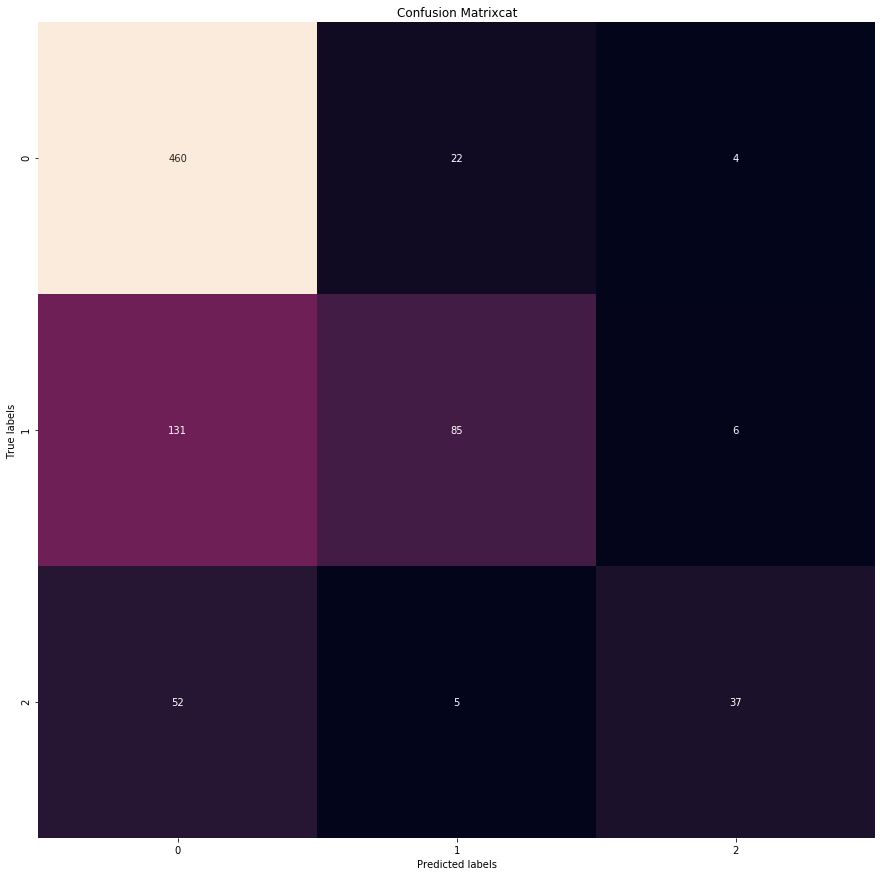

In [29]:
get_confusion_matrix(val_y,y_preds[0],'cat')

In [ ]:
for fold_id, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
    #print(train_index)
    X_tr = train_X[train_index]
    X_val = train_X[valid_index]
    y_tr = train_y[train_index]
    y_val = train_y[valid_index]

    train_pool = Pool(
        X_tr, 
        y_tr, 
        cat_features=categorical_cols,
        text_features=text_cols,
        feature_names=list(X_tr)
    )
    valid_pool = Pool(
        X_val, 
        y_val, 
        cat_features=categorical_cols,
        text_features=text_cols,
        feature_names=list(X_tr)
    )

    model = CatBoostClassifier(**catboost_params,loss_function='MultiClass',  eval_metric='Accuracy',)
    model.fit(train_pool, eval_set=valid_pool)

    oof_train[valid_index] = model.predict_proba(X_val)[:, 1]

    y_pred = model.predict_proba(X_test)[:, 1]
    y_preds.append(y_pred)
    models.append(model)